# Computer Vision: Melanoma Classifier
___

## Student 1: Antonio Castañares, A20599898
## Student 2: Nicolás Corsini, A20599305

___

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, RandomFlip, RandomRotation, Dropout
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Auxiliary functions

In [ ]:
# Plot the number of elements per each label
def distribution_plot(path):
    train_benign = len([file for file in os.listdir(path + '/train/benign')])
    train_malignant = len([file for file in os.listdir(path + '/train/malignant')])
    test_benign = len([file for file in os.listdir(path + '/test/benign')])
    test_malignant = len([file for file in os.listdir(path + '/test/malignant')])

    train_distribution = [train_benign,train_malignant]
    test_distribution = [test_benign,test_malignant]

    plt.figure(figsize=(12,6))
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.title('Distribution of train')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.bar(['benign', 'malignant'], train_distribution, color=['blue', 'orange'])
    plt.subplot(1,2,2)
    plt.title('Distribution of test')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.bar(['benign', 'malignant'], test_distribution, color=['blue', 'orange'])
    plt.show()

# Take a batch of the dataset and plot 6 images
def visualization_images(tf_dataset,tf_name):
    plt.figure(figsize=(6,5))
    plt.title(f'Examples in {tf_name}')
    plt.axis('off')
    for image_batch, label_batch in tf_train.take(1):
        for i in range(6):
            ax = plt.subplot(2,3,i+1)
            plt.imshow(image_batch[i].numpy().astype('uint8'))
            plt.title(class_names[label_batch[i]])
            plt.axis('off')

# Normalize the dataset
def Normalizer(image, label):
    image= tf.cast(image/255., tf.float32)
    return image, label

def training_performance(train_history):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_history.history['accuracy'])
  plt.plot(train_history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.subplot(1, 2, 2)
  plt.plot(train_history.history['loss'])
  plt.plot(train_history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# CNN proposed in the paper
def CNN_proposed():
    model = Sequential([
        # Block 1
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        # Block 1
        Conv2D(32, (5, 5), strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=4),
        Dropout(0.1),

        # Block 2
        Conv2D(64, (5, 5), strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=4),
        Dropout(0.2),

        # Block 3
        Conv2D(64, (5, 5), strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=4),
        Dropout(0.3),

        # Block 4
        Conv2D(64, (4, 4), strides=1, padding='same', activation='relu'),
        Dropout(0.5),

        # Block 5 - Final Convolutional Layer
        Conv2D(2, (1, 1), strides=1, padding='same', activation='relu'),

        # Fully Connected Layer and Softmax for Classification
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax'),
    ])

    model.build (input_shape=(None, 256, 256, 3))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Display model architecture
    model.summary()

    return model

# This CNN have been developed by us
def our_CNN():
    model = Sequential([
      RandomFlip("horizontal_and_vertical"),
      RandomRotation(0.2),
      Conv2D(32, kernel_size=(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(32, kernel_size=(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(32, kernel_size=(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(32, kernel_size=(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(32, kernel_size=(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(32, kernel_size=(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Flatten(),
      Dense(units=64, activation="relu"),
      Dense(units=2, activation="softmax"),
    ])

    model.build (input_shape=(None, 256, 256, 3))

    model.compile(optimizer= 'adam', loss=  'sparse_categorical_crossentropy', metrics = ['accuracy',])

    model.summary()

    return model

### The dataset

The dataset consists of 10,605 images, with 9,605 images designated for training the model and 1,000 images reserved for model evaluation. The datase classifies each image as benign or malignant. 

In [ ]:
path = '/content/drive/MyDrive/CV-Project/melanoma_cancer_dataset/'

# Load the dataset from the directory
tf_train = keras.utils.image_dataset_from_directory(
    directory = path + '/train',
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size = (256, 256),
    shuffle =True,
)

tf_test= keras.utils.image_dataset_from_directory(
    directory = path + '/test',
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size= (256, 256),
    shuffle = True,
)

Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# Get the labels
class_names = tf_train.class_names

# Train is splited into train (80 %) and validation (20%)
train = tf_train.take(int(len(tf_train)*0.8)).map(Normalizer)     # Take the first 80% of the batches
val = tf_train.skip(int(len(tf_train)*0.8)).map(Normalizer)       # Skip the first 80 % of the batches
test = tf_test.map(Normalizer)

# Validation: Remember that each batch has 32 images
print('Train images: ', len(train) * 32)                          # Batches x batch size = number of images
print('Validation images: ', len(val) * 32)
print('Test images: ', len(test) * 32)
print(f'Classes: {class_names[0]} and {class_names[1]}')

Train images:  7680
Validation images:  1952
Test images:  1024
Classes: benign and malignant


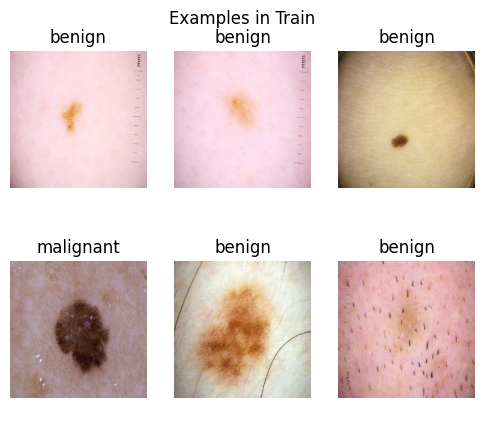

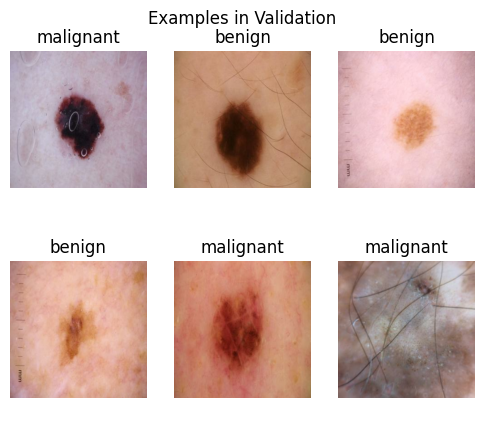

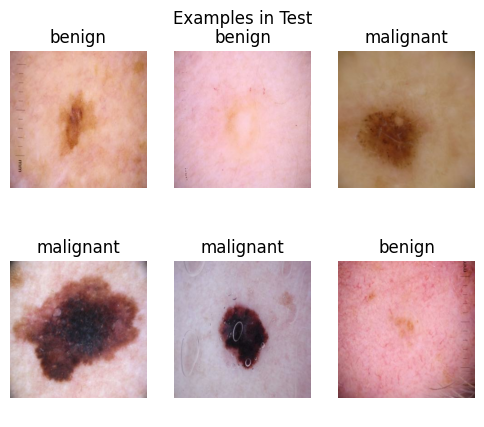

In [ ]:
# Visualization some examples of each dataset
visualization_images(train, 'Train')
visualization_images(val, 'Validation')
visualization_images(test, 'Test')

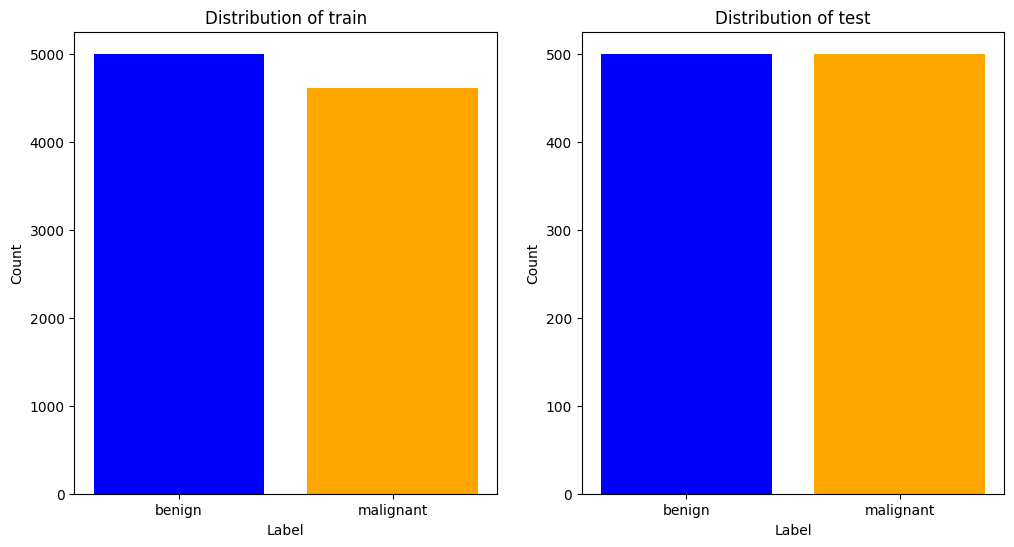

In [ ]:
# Are datasets balanced?
distribution_plot(path)

Both datasets are balanced, the number of images for each label is similar. We had problems with the previous datasets because they had 1 malignant for every 4 benign. We tried different methods to solve it (discard benign, duplicate malignant, data augmentation), but the results were disappointing.

### CNN model proposed in the paper

Main points of this architecture:
* The layers are distributed in 5 blocks.
* Each block has the following layers: convolutional, ReLU, pooling and dropout.
* Except the last block, which contains the fully connected later and the softmax layer for classification.
* The first three convolutional layers are 5x5, with padding of 2. The fourth convolutional layers has 4x4 and the last one is 1x1.
* The first convolutiona layer has 32 kernel, the rest have 64 kernels except the last one has 2 kernels.
* All convolutional layers have a stride of 1.
* The dropout rate used in the first four blocks is 0.1, 0.2, 0.3, and 0.5.

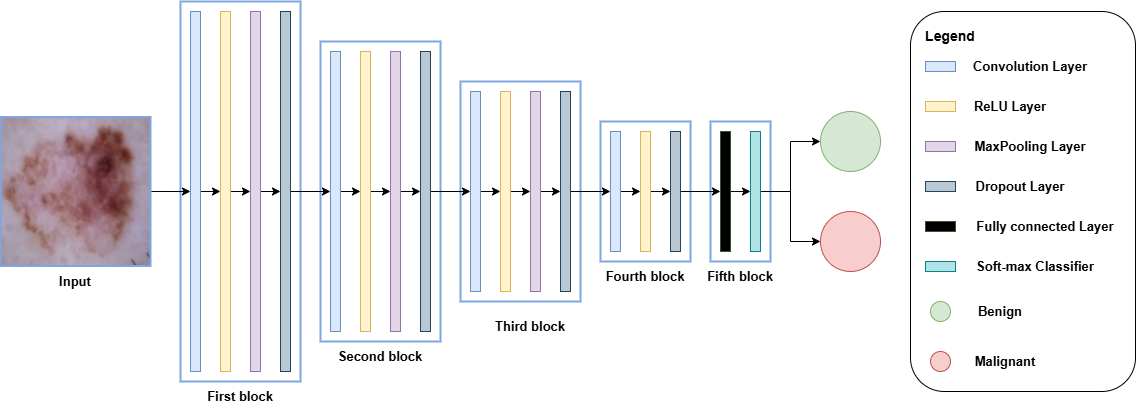

In [ ]:
# CNN_proposed is at the beginning of the notebook in Auxiliary Functions
first_model = CNN_proposed()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 2)        │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,372 (884.27 KB)

 Trainable params: 226,372 (884.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
first_history = first_model.fit(train,
                                validation_data=val,
                                epochs=10)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 72s 294ms/step - accuracy: 0.5329 - loss: 0.6854 - val_accuracy: 0.5153 - val_loss: 0.6927
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 101s 420ms/step - accuracy: 0.5156 - loss: 0.6926 - val_accuracy: 0.5158 - val_loss: 0.6927
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 153s 638ms/step - accuracy: 0.5168 - loss: 0.6927 - val_accuracy: 0.5101 - val_loss: 0.6933
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 339ms/step - accuracy: 0.5221 - loss: 0.6923 - val_accuracy: 0.5122 - val_loss: 0.6930
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.5187 - loss: 0.6926 - val_accuracy: 0.5184 - val_loss: 0.6925
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 203ms/step - accuracy: 0.5225 - loss: 0.6931 - val_accuracy: 0.5595 - val_loss: 0.6866
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 202ms/step - accuracy: 0.6151 - loss: 0.6445 - val_accuracy: 0.6681 - val_loss: 0.5893
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.6254 - loss:

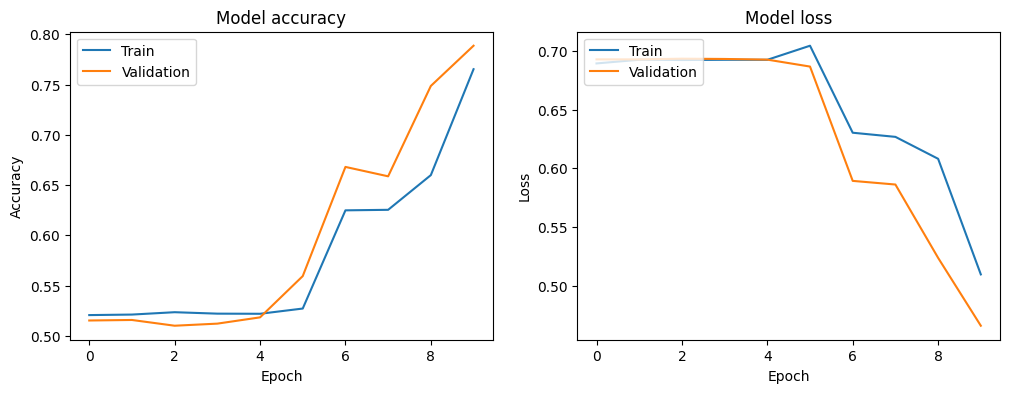

In [ ]:
# training_performance is at the beginning of the notebook in Auxiliary Functions
training_performance(first_history)

The plots show a steady increase in both training and validation accuracy, with a significant jump after epoch 5, suggesting effective learning. Validation accuracy surpasses training slightly, indicating good generalization without overfitting. The consistent decrease in both training and validation loss, with convergence around epoch 6, reflects stable optimization. Overall, the model shows balanced performance across training and validation.

### CNN proposed by us

Main points of our architecture:

*   The layers are distributed in 6 blocks.
*   Each block includes the following layers: convolutional, ReLU activation, and max pooling.
*   After the convolutional blocks, the network has a fully connected layer and a softmax layer for classification.
*   All convolutional layers use a 3x3 kernel with stride 1 and padding of 1.
*   Each convolutional layer in the blocks has 32 filters.
*   Max pooling layers use a 2x2 pooling window with a stride of 2.
*   No dropout layers are used in this architecture.
*   **Data augmentation (random flip and rotation)** is applied to improve generalization.

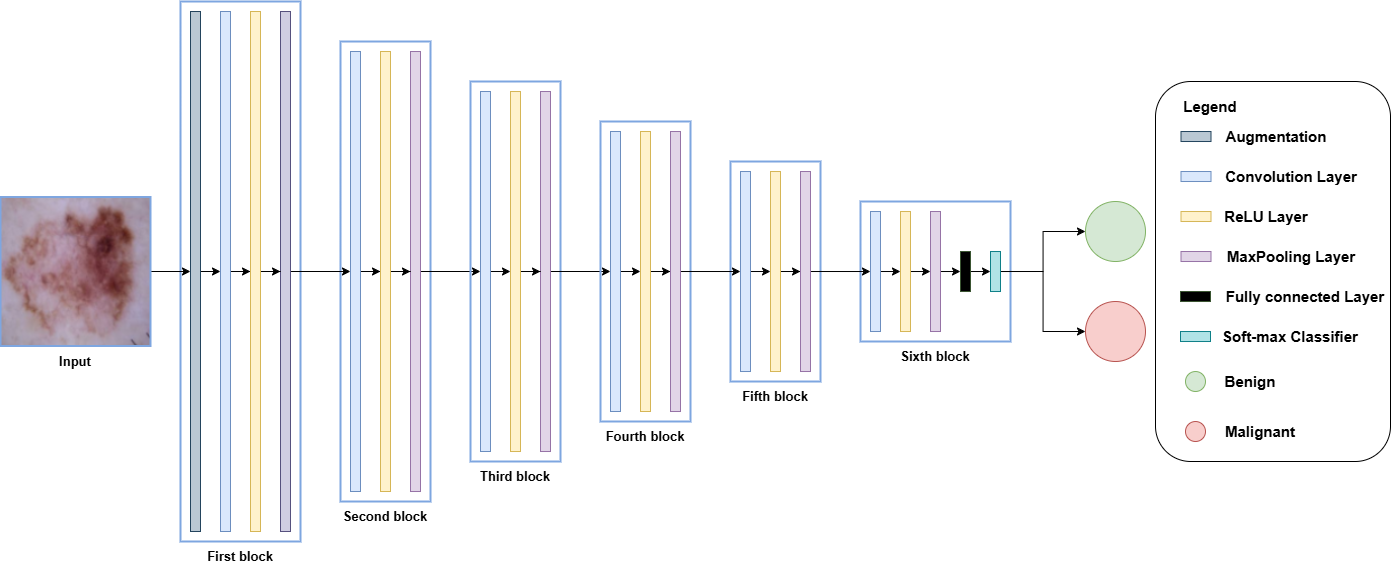

In [ ]:
# our_CNN is at the beginning of the notebook in Auxiliary Functions
second_model = our_CNN()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,522 (216.88 KB)

 Trainable params: 55,522 (216.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
second_history = second_model.fit(train,
                                  validation_data=val,
                                  epochs=10)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 192ms/step - accuracy: 0.6640 - loss: 0.5755 - val_accuracy: 0.8592 - val_loss: 0.3334
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 45s 187ms/step - accuracy: 0.8514 - loss: 0.3473 - val_accuracy: 0.8540 - val_loss: 0.3488
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.8577 - loss: 0.3324 - val_accuracy: 0.8753 - val_loss: 0.3153
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.8600 - loss: 0.3197 - val_accuracy: 0.8790 - val_loss: 0.2911
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 190ms/step - accuracy: 0.8691 - loss: 0.3090 - val_accuracy: 0.8727 - val_loss: 0.2982
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - accuracy: 0.8738 - loss: 0.2948 - val_accuracy: 0.8748 - val_loss: 0.2947
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 193ms/step - accuracy: 0.8738 - loss: 0.2880 - val_accuracy: 0.8665 - val_loss: 0.3337
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.8760 - loss: 0

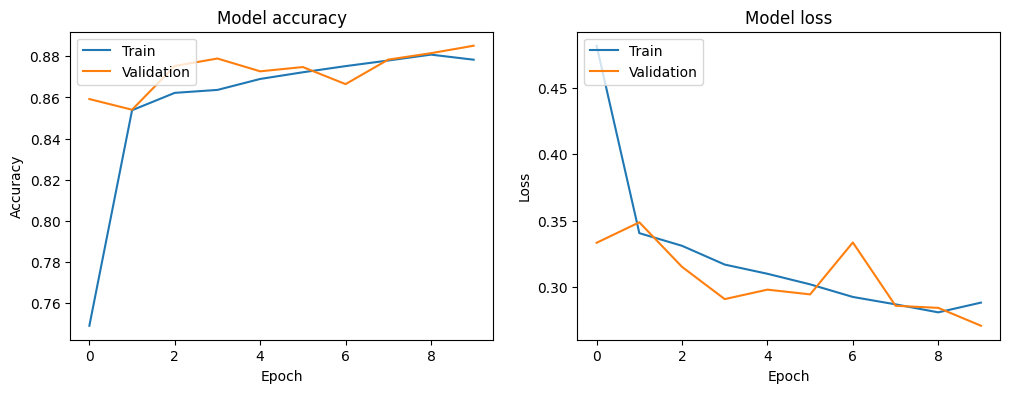

In [ ]:
# training_performance is at the beginning of the notebook in Auxiliary Functions
training_performance(second_history)

Training and validation accuracy stabilize quickly, reaching around 86-88% accuracy within the first few epochs, suggesting efficient learning. The loss curves show a sharp initial decrease and then gradual convergence, with minimal divergence between training and validation loss, indicating low overfitting. The consistency between training and validation performance implies good generalization

In [ ]:
first_loss, first_accuracy = first_model.evaluate(test)
print('Test Loss:', first_loss)
print('Test Accuracy:', first_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8297 - loss: 0.3990
Test Loss: 0.4347701072692871
Test Accuracy: 0.8100000023841858


In [ ]:
second_loss, second_accuracy = second_model.evaluate(test)
print('Test Loss:', second_loss)
print('Test Accuracy:', second_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9103 - loss: 0.2165
Test Loss: 0.24253959953784943
Test Accuracy: 0.8930000066757202


The second model outperforms the first, achieving higher accuracy (91.03% vs. 81.0%) and lower loss (0.2165 vs. 0.3990) on the test set.

In [ ]:
# Save the model for reuse later
first_model.save('first_model.keras')
second_model.save('second_model.keras')

### Model prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


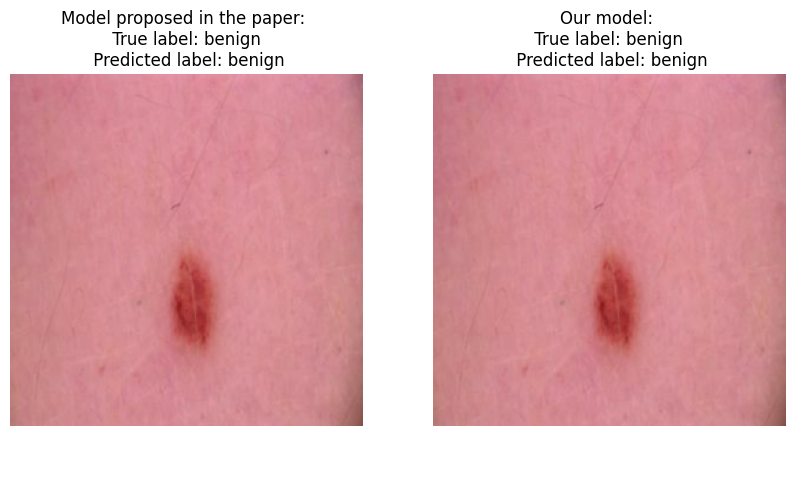

In [ ]:
# Select one image and predict its label using both models
for images,label in test.take(1):
  Y_first_pred = first_model.predict(images)
  Y_second_pred = second_model.predict(images)
  img = (images[0].numpy() * 255).astype('uint8') if images[0].numpy().max() <= 1 else images[0].numpy().astype('uint8')
  plt.figure(figsize=(10, 6))
  plt.axis('off')
  plt.subplot(1,2,1)
  plt.axis('off')
  plt.imshow(img)
  plt.title(f'Model proposed in the paper: \n True label: {class_names[label[0].numpy()]} \n Predicted label: {class_names[np.argmax(Y_first_pred[0])]}')
  plt.subplot(1,2,2)
  plt.axis('off')
  plt.imshow(img)
  plt.title(f'Our model: \n True label: {class_names[label[0].numpy()]} \n Predicted label: {class_names[np.argmax(Y_second_pred[0])]}')

In [ ]:
# We get the true and the predictions by each model
true_labels, first_predictions, second_predictions = [], [], []
for images, labels in test:
    for img, label in zip(images, labels):
        true_labels.append(label.numpy())
        first_pred = first_model.predict(tf.expand_dims(img, axis=0))
        first_predictions.append(np.argmax(first_pred[0]))
        second_pred = second_model.predict(tf.expand_dims(img, axis=0))
        second_predictions.append(np.argmax(second_pred[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

### Model performance

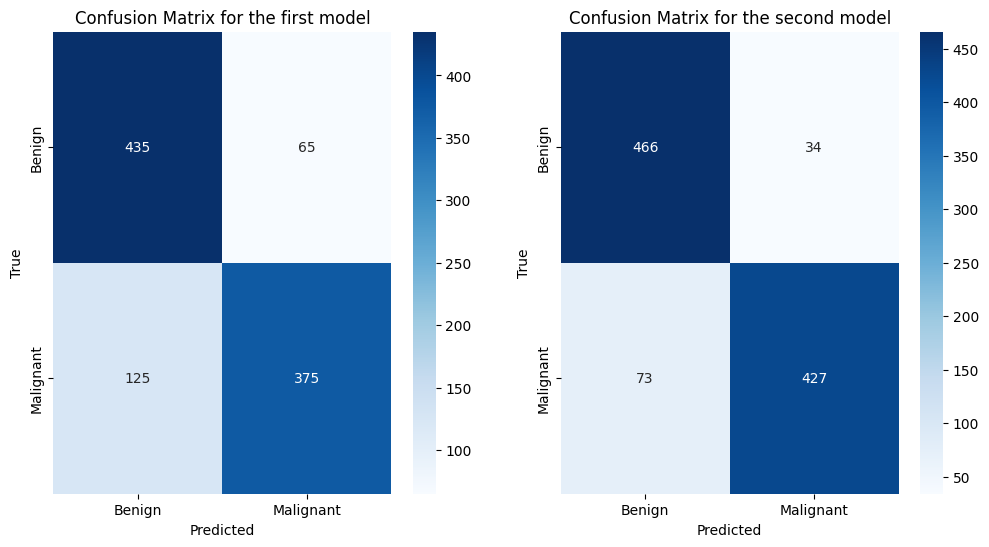

In [ ]:
# Build the confision matrix for each model
first_cm = confusion_matrix(true_labels, first_predictions)
second_cm = confusion_matrix(true_labels, second_predictions)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Confusion Matrix for the first model')
sns.heatmap(first_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(1,2,2)
plt.title('Confusion Matrix for the second model')
sns.heatmap(second_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
tn, fp, fn, tp = first_cm.ravel()

specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Specificity for the first model:", specificity)
print("Sensitivity for the first model:", sensitivity)

tn, fp, fn, tp = second_cm.ravel()

specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Specificity for the second model:", specificity)
print("Sensitivity for the second model:", sensitivity)

Specificity for the first model: 0.87
Sensitivity for the first model: 0.75
Specificity for the second model: 0.932
Sensitivity for the second model: 0.854
